In [11]:
import pandas as pd
import numpy as np
import torch

In [16]:
TRAINING_PATH = 'BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Training'
TESTING_PATH = 'BenchmarkDatasets/NoAuction/3.NoAuction_DecPre/NoAuction_DecPre_Testing'

dec_data = np.loadtxt(f'{TRAINING_PATH}/Train_Dst_NoAuction_DecPre_CF_7.txt')


dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt(f'{TESTING_PATH}/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [20]:
def prepare_x(data):
    df = pd.DataFrame(data)
    df40 = df.iloc[:40, :].T
    new_column_names = []
    for i in range(1, 11):
        new_column_names.append(f"ask_price_level_{i}")
        new_column_names.append(f"ask_volume_level_{i}")
        new_column_names.append(f"bid_price_level_{i}")
        new_column_names.append(f"bid_volume_level_{i}")
    
    df40.columns = new_column_names
    return df40

def get_label(data):
    df = pd.DataFrame(data)
    lob = df.iloc[-5:, :].T
    horizon = [1, 2, 3, 5, 10]
    new_column_names = []
    for i in range(5):
        new_column_names.append(f"Horizon at {horizon[i]}")
    
    lob.columns = new_column_names
    return lob

In [52]:
df_x = prepare_x(dec_train)
df_y_train = get_label(dec_train)


In [57]:
def create_volatility_label(df_x, horizons) :
    """
    Compute rolling volatility labels for specified horizons based on log returns.

    This function calculates the mid-price, computes the log returns, 
    and derives rolling standard deviations (volatility) for each horizon 
    in the provided list. It cleans up the data by dropping rows with NaN values.

    Parameters:
    ----------
    df_x : pd.DataFrame
        Input DataFrame containing at least bid and ask price columns.
        Assumes bid prices are in column index 0 and ask prices in column index 2.
        
    horizons : list of int
        A list of integers representing the rolling window sizes (horizons) 
        for which to calculate realized volatility.

    Returns:
    """
    pd.DataFrame
        A DataFrame with additional columns:
        - 'MidPrice': The calculated mid-price for each row.
        - 'LogReturn': The log return of the mid-price.
        - 'RV_{k}': Rolling standard deviation (realized volatility) 
          for each horizon `k` in the list of horizons.
    
    df_x['MidPrice'] = (df_x.iloc[:, 2] + df_x.iloc[:, 0])/2
    df_x['LogReturn'] = np.log(df_x['MidPrice'] / df_x['MidPrice'].shift(1))

    df_x = df_x.iloc[1:].reset_index(drop=True)

    for k in horizons:
        df_x[f'RV_{k}'] = df_x['LogReturn'].rolling(window=k).std()
    df_x.dropna(inplace=True)
    return df_x
df_x_volatility = create_volatility_label(df_x, [10, 20, 30, 50, 100])

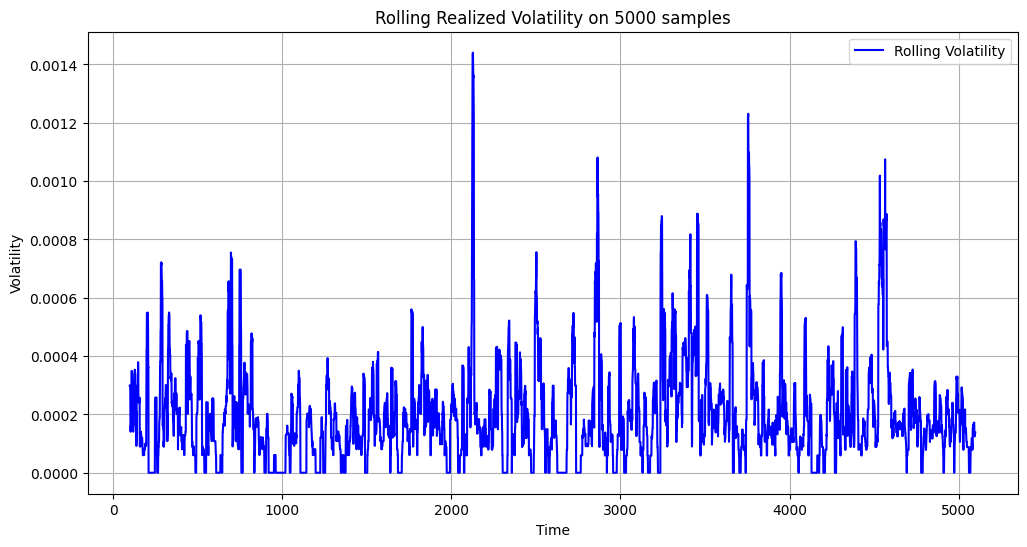

In [67]:
import matplotlib.pyplot as plt

sample_data = df_x_volatility['RV_10'].iloc[:5000]

plt.figure(figsize=(12, 6))
plt.plot(sample_data, label='Rolling Volatility', color='blue')
plt.title('Rolling Realized Volatility on 5000 samples')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()